# Part 3 - Clustering, Topic Modeling, Keyword

#### 01 - Load Data and Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
df = pd.read_csv('./data/tweets_with_sentiment_label.csv')
df = df[df['is_spam'] == 'not_spam']
df

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_spam,preprocessed_text,label_vader,label_textblob,label_roberta
0,Tushar Gupta at DevFest Raipur.,Is this the end of Twitter threads?\n#AI #Chat...,India,•Experiencing Life💬 && Tech🥑 •Learning about💻:...,2021-10-05 05:05:55+00:00,230.0,438.0,1567,False,2022-12-20 13:29:08+00:00,"['AI', 'ChatGPT']",Twitter for Android,not_spam,end twitter thread ai chatgpt openai,0,0,0
1,PharmaTechnologyTrends,ChatGPT is a truly mind-blowing tool and playi...,"Frankfurt am Main, Deutschland",Latest News and Trends in Pharmaceutical Industry,2022-11-06 21:03:59+00:00,264.0,4333.0,24,False,2022-12-20 13:28:50+00:00,NaN,EveryoneSocial,not_spam,chatgpt truli tool play around definit send ra...,1,0,1
2,Richard Kim,#ChatGPT can be used to generate malicious cod...,NaN,"News, papers, and books on AI, Machine Learnin...",2010-05-06 00:20:48+00:00,4481.0,4982.0,18412,False,2022-12-20 13:28:39+00:00,"['ChatGPT', 'code', 'chatgpt', 'language', 'ai...",shem0304,not_spam,chatgpt use gener malici code find research co...,0,0,-1
3,GiamMa-based researchers SDR R&D IoT,Use prompt hack to bypass OpenAI's content pol...,NaN,#ArtTechnology #IT #Hardware #Security #OSINT ...,2020-08-29 09:30:40+00:00,1996.0,1190.0,19528,False,2022-12-20 13:28:09+00:00,NaN,Twitter Web App,not_spam,use prompt hack bypass openai content polici r...,-1,0,0
4,"Bobby Davis, Jr.",Why #chatgpt will never replace devs. \n\nhttp...,North Carolina,CEO @CoderFoundry\nAuthor: Breaking the Code h...,2012-06-25 17:36:19+00:00,1182.0,245.0,888,False,2022-12-20 13:27:10+00:00,['chatgpt'],Twitter for Android,not_spam,chatgpt never replac dev,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39049,(I)(AM)(T)(MOYO),"Levels🙏🙏🙏,so happy for the chatGPT team for co...",Satoshi Island,Blockchain Enthusiast || Philanthropist || a S...,2013-12-07 16:38:30+00:00,3419.0,4994.0,16659,False,2022-12-05 17:10:31+00:00,NaN,Twitter for Android,not_spam,happi chatgpt team com8ng revolutionari futur ...,1,1,1
39050,Green,Iterating back-and-forth with tools like #Chat...,🍁,NaN,2022-12-03 12:49:13+00:00,3.0,33.0,3,False,2022-12-05 17:09:22+00:00,['ChatGPT'],Twitter Web App,not_spam,iter tool like chatgpt probabl chang use compu...,1,-1,0
39051,Gabriel Furstenheim,Russel vs ChatGPT. It's also funny that it tak...,NaN,Mathematician and Developer @Amazon. Previousl...,2016-07-09 21:08:52+00:00,80.0,34.0,169,False,2022-12-05 17:09:04+00:00,['ChatGPT'],Twitter for Android,not_spam,russel vs chatgpt also funni take long time an...,0,0,0
39052,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Twitter for Android,not_spam,wonder differ jasper chatgpt gpt3 chatgpt gpt3,0,0,0


In [3]:
# remove some general words
words_to_remove = ["chatgpt", "openai", "gpt"]
words_to_remove = [word.lower() for word in words_to_remove]

def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [w for w in tokens if w not in words_to_remove]
    filtered_text = ' '.join(filtered_tokens)
    filtered_text = re.sub(r'[^a-zA-Z\s]', '', filtered_text)
    return filtered_text
    
df['preprocessed_text'] = df['preprocessed_text'].apply(clean_text)

#### 02 - Word Cloud

In [4]:
# Organize word frequency by sentiment

vectorizer = TfidfVectorizer(stop_words='english')
sentiments = df['label_roberta'].unique()
word_freq_by_sentiment = {}

for sentiment in sentiments:

    sentiment_text = df[df['label_roberta'] == sentiment]['preprocessed_text']
    X = vectorizer.fit_transform(sentiment_text)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.sum(X, axis=0).A1
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    word_freq = Counter({word: int(tfidf_scores[idx]) for word, idx in vectorizer.vocabulary_.items()})
    word_freq_by_sentiment[sentiment] = word_freq

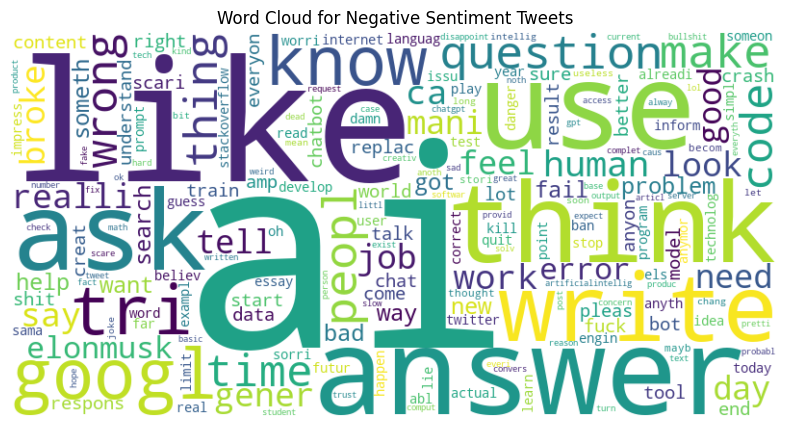

In [5]:
# negative word cloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
).generate_from_frequencies(word_freq_by_sentiment[-1])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment Tweets')
plt.show()

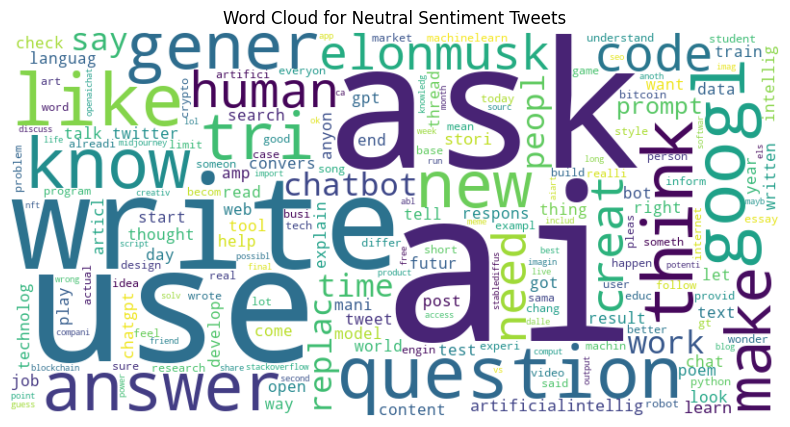

In [6]:
# neutral word cloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
).generate_from_frequencies(word_freq_by_sentiment[0])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment Tweets')
plt.show()

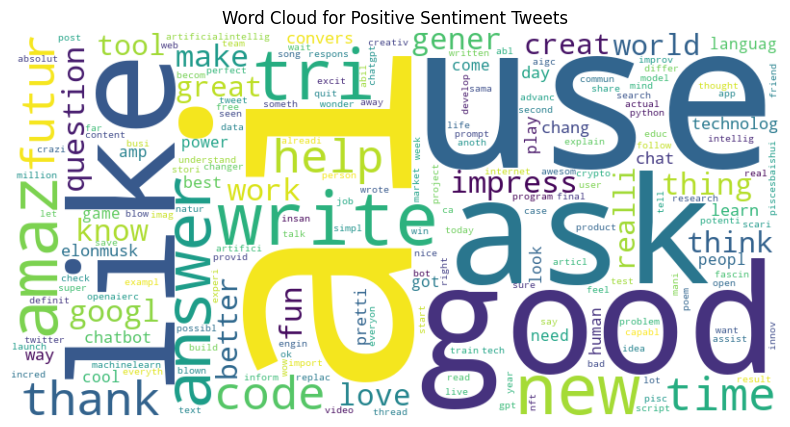

In [7]:
# positive word cloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
).generate_from_frequencies(word_freq_by_sentiment[1])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

#### 03 - Clustering

In [8]:
X = vectorizer.fit_transform(df['preprocessed_text'])

In [9]:
# Use the elbow method to find the optimal number of clusters. Search range: 2-12.
wcss = []
silhouette_scores = []
K = range(2, 12)
for k in K:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11


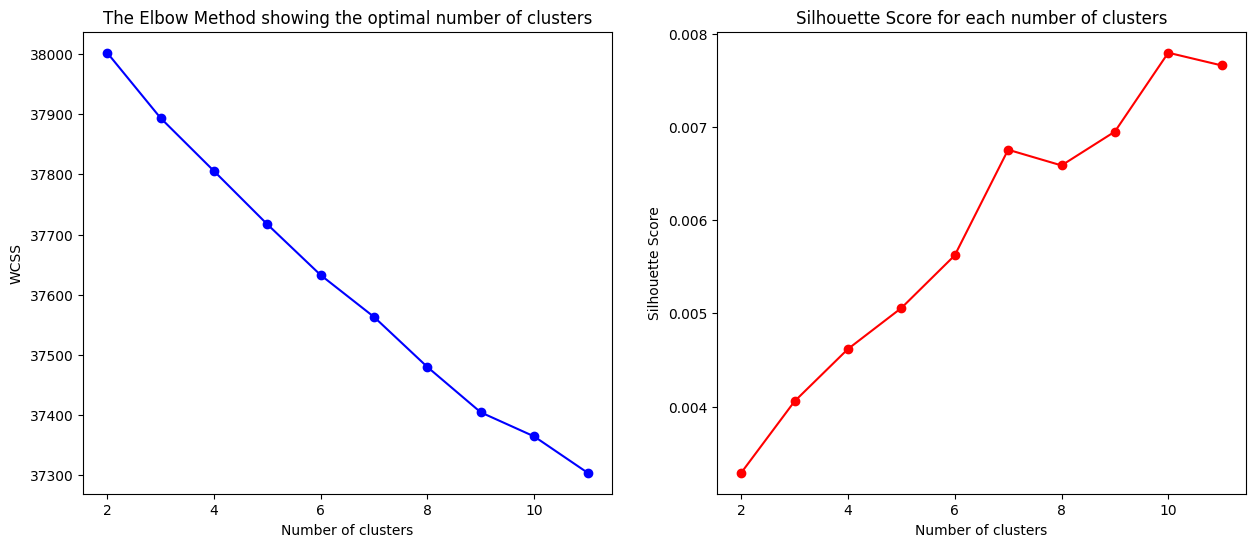

In [10]:
# visualize Elbow and Silhouette Score
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(K, wcss, 'bo-')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')
axs[0].set_title('The Elbow Method showing the optimal number of clusters')

axs[1].plot(K, silhouette_scores, 'ro-')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score for each number of clusters')

plt.show()

- Based on the combined results of the Elbow method and Silhouette Score, we choose optimal_k = 9.

In [11]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=44)
kmeans.fit(X)
df['cluster'] = kmeans.labels_

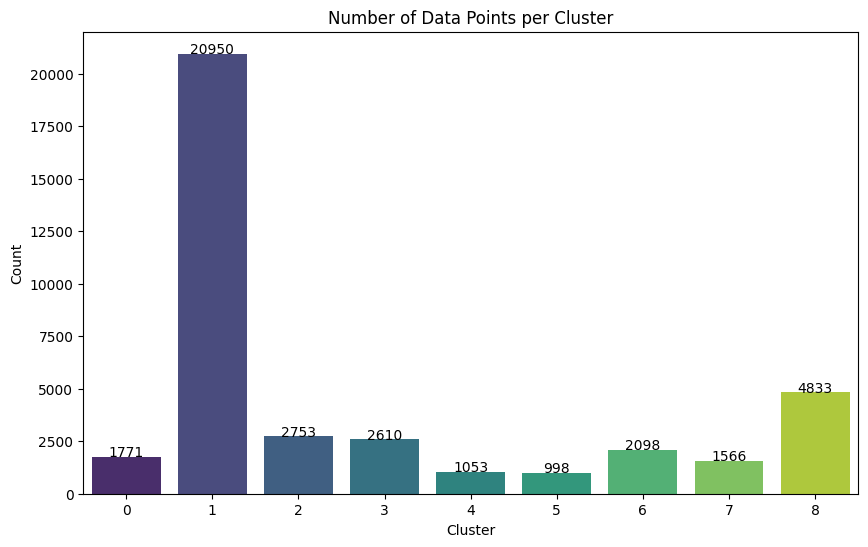

In [12]:
# visualize the number of data points per cluster

cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Number of Data Points per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(len(cluster_counts)))
for index, value in enumerate(cluster_counts.values):
    plt.text(index, value, str(value), ha='center')
    
plt.show()

In [13]:
# print some text
for i in range(optimal_k):
    print("-----*CLUSTER_"+str(i)+"*-----")
    print("FIVE SAMPLE:\n",df[df['cluster'] ==i]['text'].values[:5])

-----*CLUSTER_0*-----
FIVE SAMPLE:
 ['#ChatGPT is a powerful open-source natural language processing tool that can be used for a variety of tasks. It has the ability to generate human-like conversations, identify potential customer needs, and answer frequently asked questions.'
 'So in the past few days, #ChatGPT has helped me update my CV, freshen up my LinkedIn page and helped me answer questions for a verbal assessment i had to do for a job application. I love the future.'
 'You may have come across #ChatGPT, an impressive AI chatbot system that answers questions, admits mistakes and rejects inappropriate requests. The chatbot has reached 1 million users &amp; in our latest podcast episode the team discuss it’s uses for marketers: https://t.co/V09QNlwLpC https://t.co/ipl6sBrEDK'
 "Yes, I think ChatGPT will prove to be mindblowing, but right now remember one thing: it is NOT connected to the internet so it can't provide everything you want. Can answer questions, but not if it has to 

#### 04 - Topic Modeling

Analyzing Cluster 0
Analyzing Cluster 1
Analyzing Cluster 2
Analyzing Cluster 3
Analyzing Cluster 4
Analyzing Cluster 5
Analyzing Cluster 6
Analyzing Cluster 7
Analyzing Cluster 8


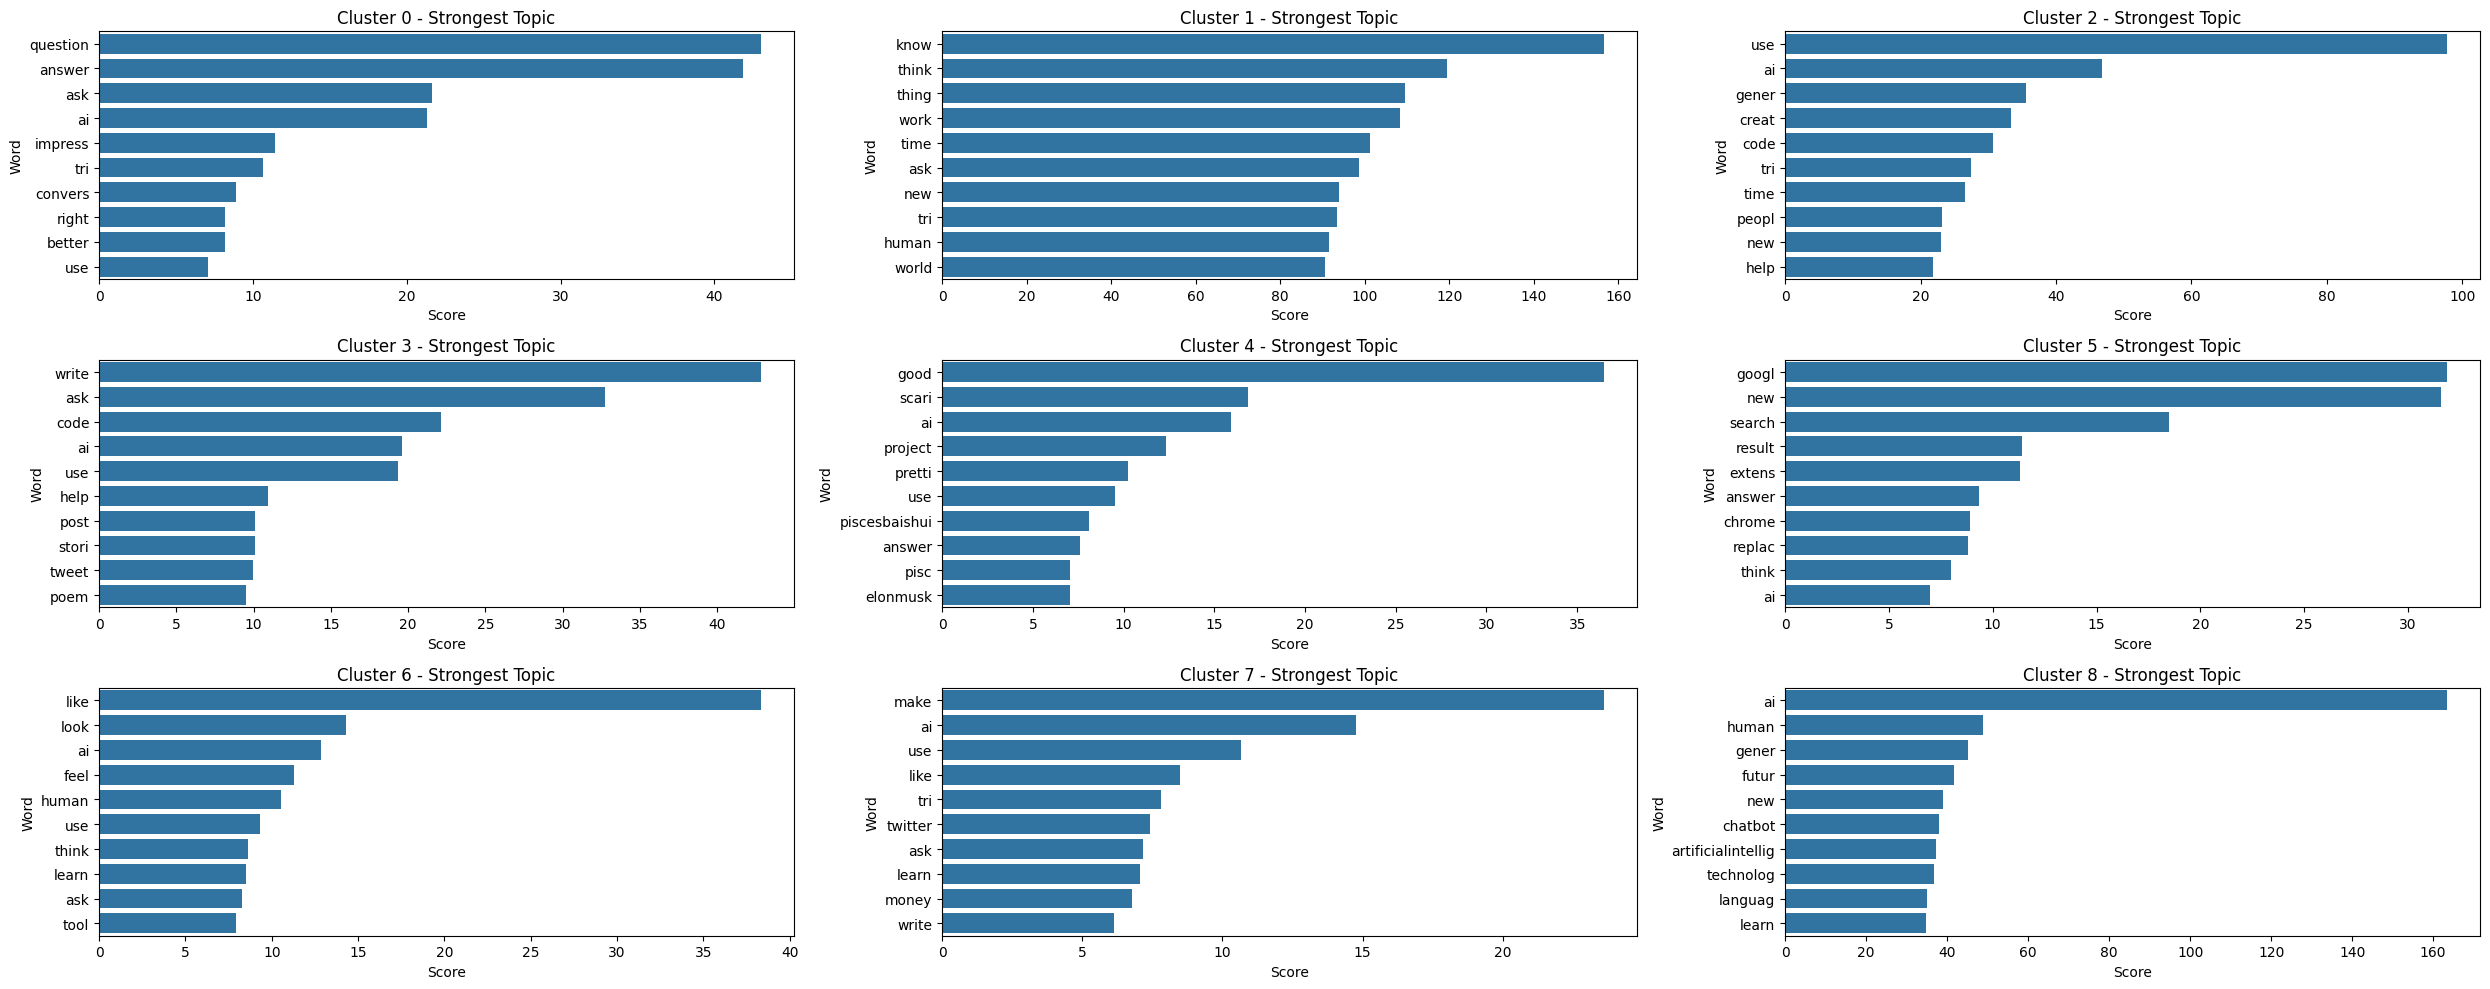

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 10))
axes = axes.flatten() 
all_top_features = []
top_words = 10

for cl in range(optimal_k):
    print("Analyzing Cluster " + str(cl))
    cluster_docs = df[df['cluster'] == cl]['preprocessed_text']
    X_cluster = vectorizer.fit_transform(cluster_docs)

    topic_k = 5

    lda_best = LatentDirichletAllocation(n_components=topic_k, random_state=42)
    lda_best.fit(X_cluster)

    feature_names = vectorizer.get_feature_names_out()

    topic_distributions = lda_best.transform(X_cluster)
    dominant_topics = np.argmax(topic_distributions, axis=1)
    strongest_topic = np.bincount(dominant_topics).argmax()

    strongest_topic_words = lda_best.components_[strongest_topic]
    top_indices = strongest_topic_words.argsort()[-top_words:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [strongest_topic_words[i] for i in top_indices]
    all_top_features.append(top_features)
    
    sns.barplot(x=top_scores, y=top_features, ax=axes[cl])
    axes[cl].set_title(f"Cluster {cl} - Strongest Topic")
    axes[cl].set_xlabel("Score")
    axes[cl].set_ylabel("Word")

plt.tight_layout()
plt.show()

In [15]:
all_top_features

[['question',
  'answer',
  'ask',
  'ai',
  'impress',
  'tri',
  'convers',
  'right',
  'better',
  'use'],
 ['know',
  'think',
  'thing',
  'work',
  'time',
  'ask',
  'new',
  'tri',
  'human',
  'world'],
 ['use',
  'ai',
  'gener',
  'creat',
  'code',
  'tri',
  'time',
  'peopl',
  'new',
  'help'],
 ['write',
  'ask',
  'code',
  'ai',
  'use',
  'help',
  'post',
  'stori',
  'tweet',
  'poem'],
 ['good',
  'scari',
  'ai',
  'project',
  'pretti',
  'use',
  'piscesbaishui',
  'answer',
  'pisc',
  'elonmusk'],
 ['googl',
  'new',
  'search',
  'result',
  'extens',
  'answer',
  'chrome',
  'replac',
  'think',
  'ai'],
 ['like',
  'look',
  'ai',
  'feel',
  'human',
  'use',
  'think',
  'learn',
  'ask',
  'tool'],
 ['make',
  'ai',
  'use',
  'like',
  'tri',
  'twitter',
  'ask',
  'learn',
  'money',
  'write'],
 ['ai',
  'human',
  'gener',
  'futur',
  'new',
  'chatbot',
  'artificialintellig',
  'technolog',
  'languag',
  'learn']]

- Title for each cluster:
- [CLUSTER 0] ChatGPT's Insightful Interactions: Involving questions, answers, and impressive AI-driven conversations.
- [CLUSTER 1] ChatGPT's Cognitive Worldview: Reflecting thoughts, works, and human-world explorations.
- [CLUSTER 2] ChatGPT's Creative Coding: Highlighting AI's use in generating, creating, and coding new ideas.
- [CLUSTER 3] ChatGPT's Artistic Authorship: Focused on writing, coding assistance, and AI-enhanced storytelling.
- [CLUSTER 4] ChatGPT's Diverse Dimensions: Covering AI's intriguing aspects from scary to impressive, including references to notable figures.
- [CLUSTER 5] ChatGPT's Search and Replace: Focusing on Google, new searches, and AI's role in enhancing browsing experiences.
- [CLUSTER 6] ChatGPT's Human-Like Perception: Emphasizing AI's human-like appearance, feelings, and learning tools.
- [CLUSTER 7] ChatGPT's Twitter Takeover: Concerning AI's use in social media, learning, and content creation.
- [CLUSTER 8] ChatGPT's Future Forefront: Discussing AI's role in shaping future technologies, language learning, and artificial intelligence advancements.

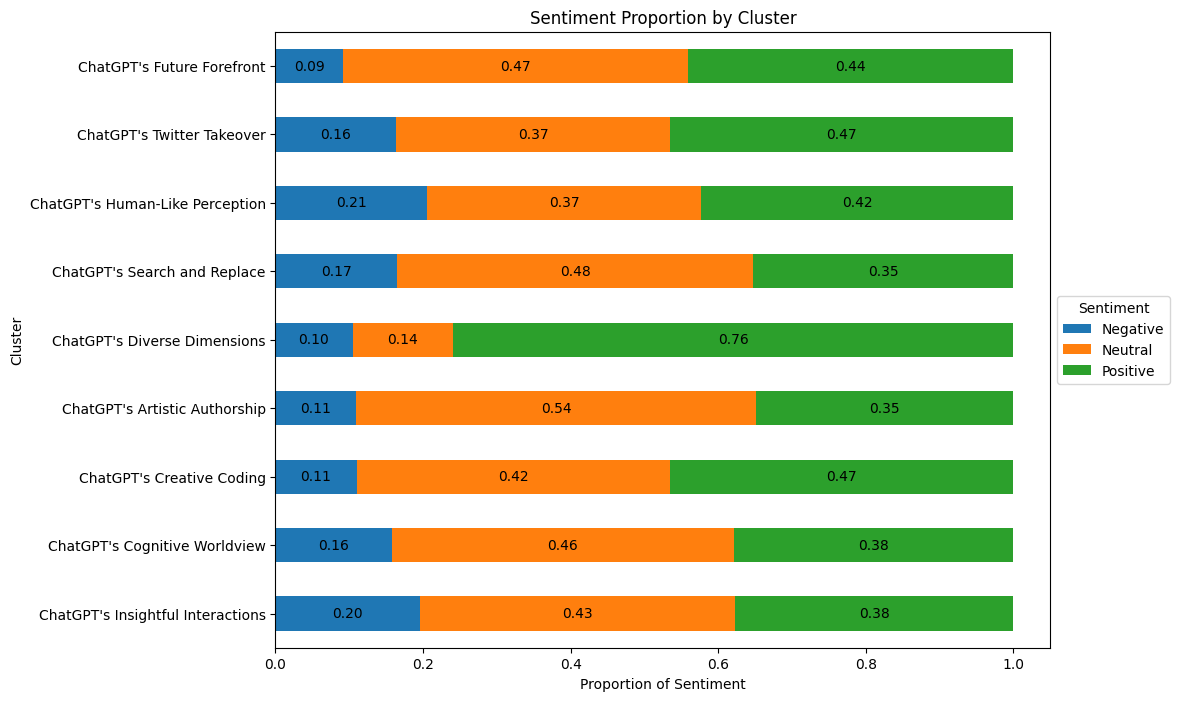

In [16]:
# Define a title for each cluster
cluster_titles = [
    "ChatGPT's Insightful Interactions",
    "ChatGPT's Cognitive Worldview",
    "ChatGPT's Creative Coding",
    "ChatGPT's Artistic Authorship",
    "ChatGPT's Diverse Dimensions",
    "ChatGPT's Search and Replace",
    "ChatGPT's Human-Like Perception",
    "ChatGPT's Twitter Takeover",
    "ChatGPT's Future Forefront"
]

cluster_sentiment_counts = df.groupby('cluster')['label_roberta'].value_counts(normalize=True).unstack()

ax = cluster_sentiment_counts.plot(kind='barh', stacked=True, figsize=(10, 8))
ax.set_yticklabels(cluster_titles)

plt.ylabel('Cluster')
plt.xlabel('Proportion of Sentiment')
plt.title('Sentiment Proportion by Cluster')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'], loc='center left', bbox_to_anchor=(1, 0.5))

for p in ax.patches:
    width = p.get_width()
    if width > 0.05:
        ax.text(p.get_x() + width/2, 
                p.get_y() + p.get_height()/2, 
                f'{width:.2f}', 
                ha='center', 
                va='center')

plt.show()

#### 05 - Keyword Visualization

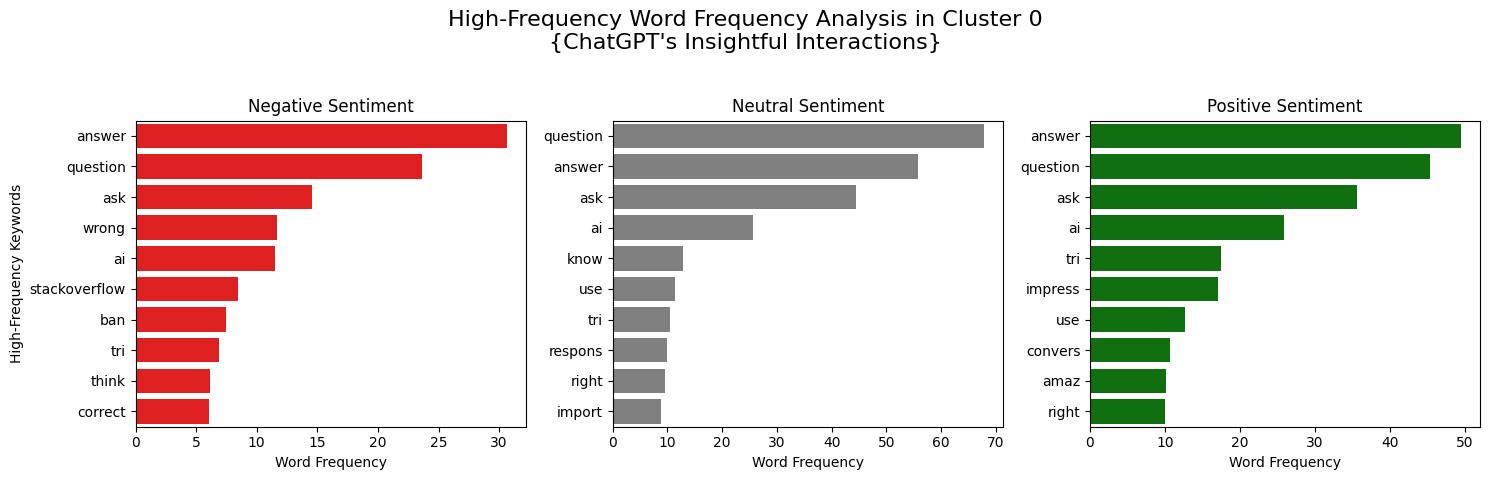

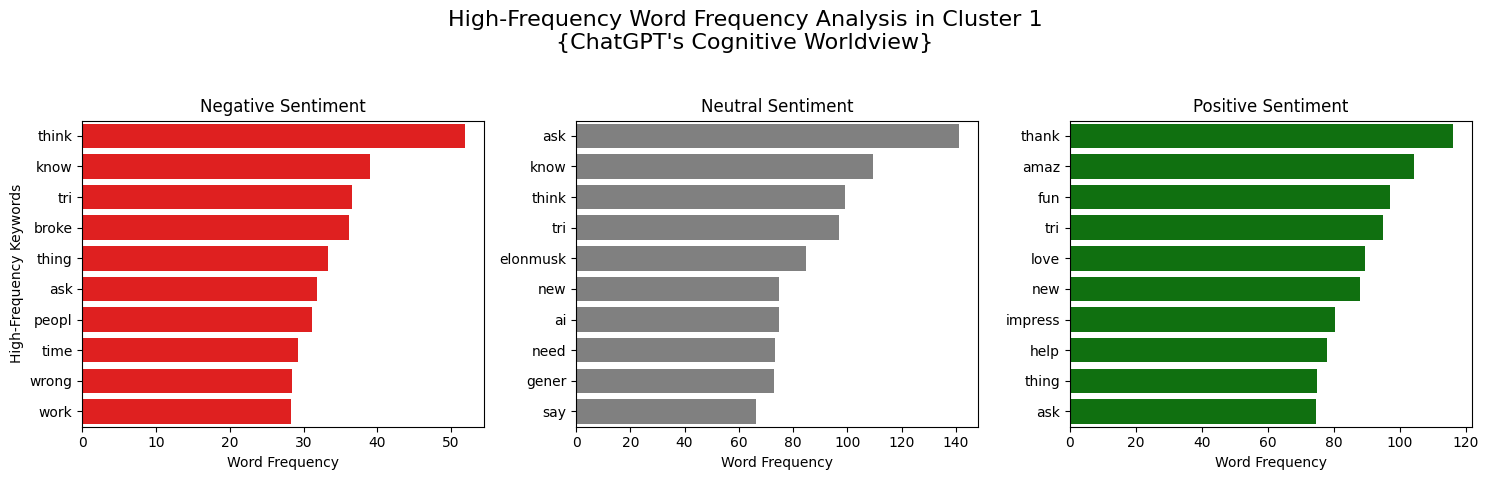

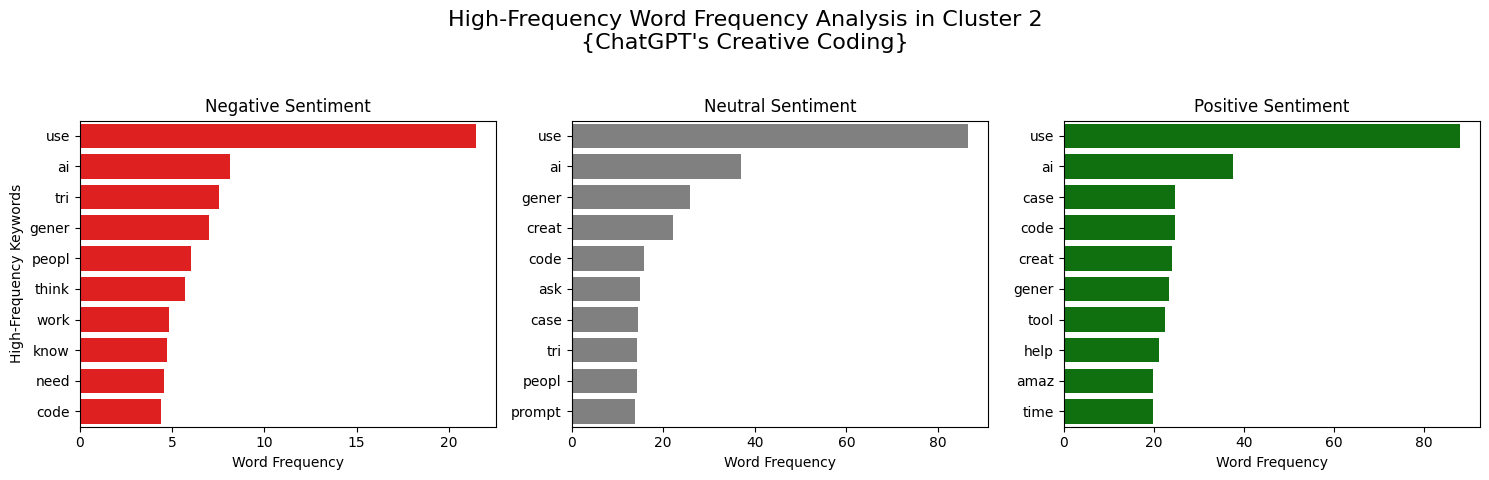

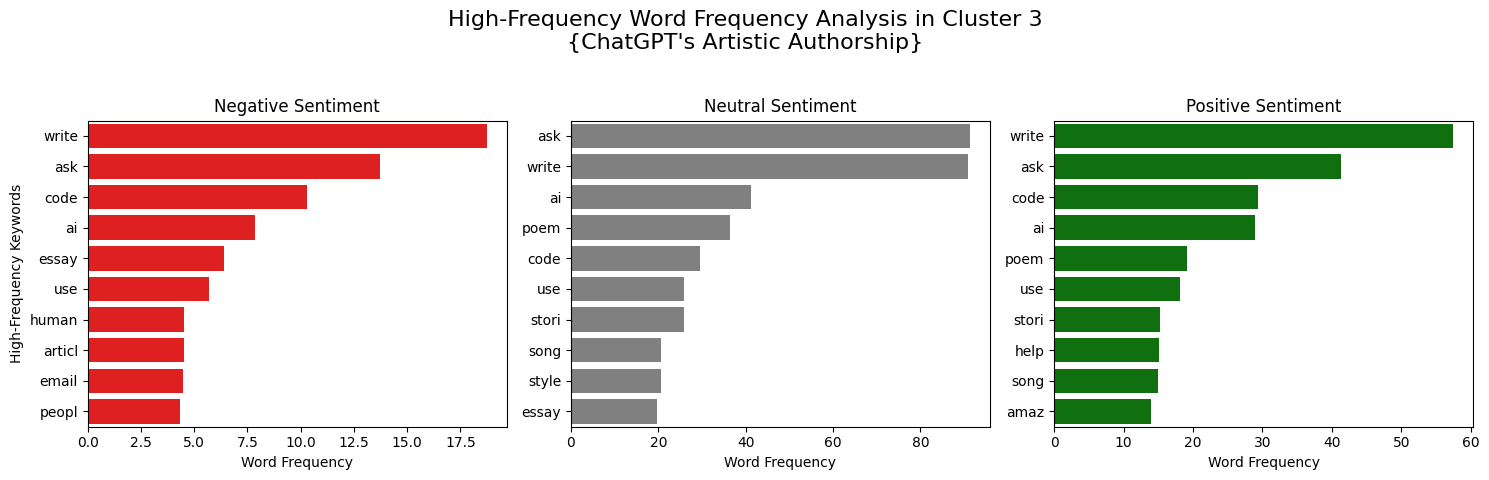

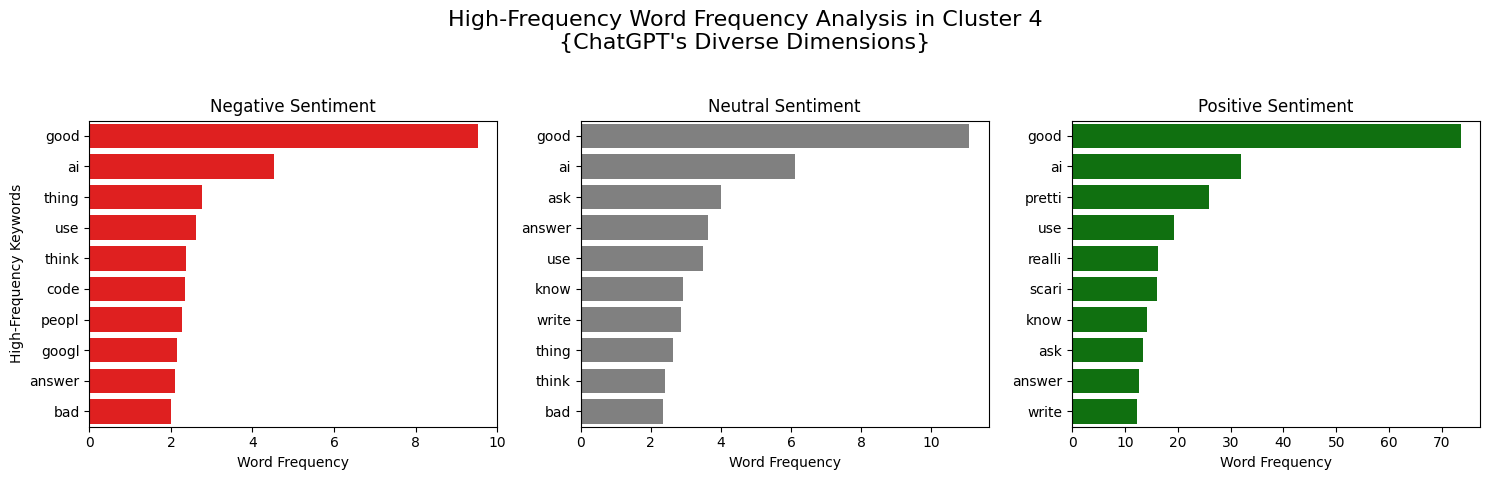

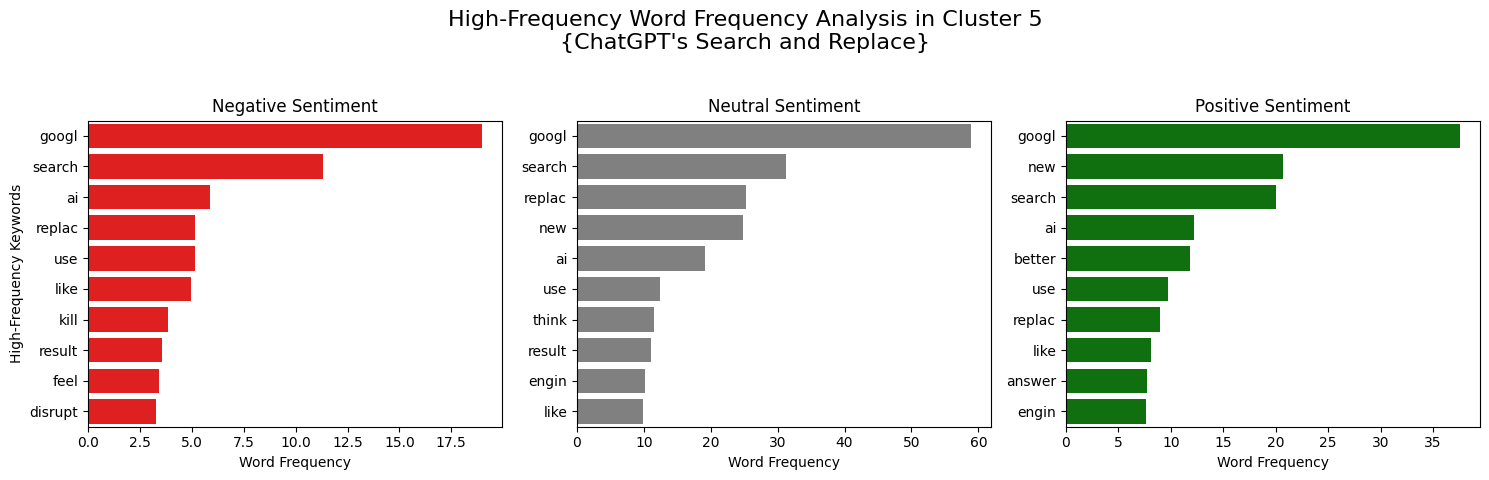

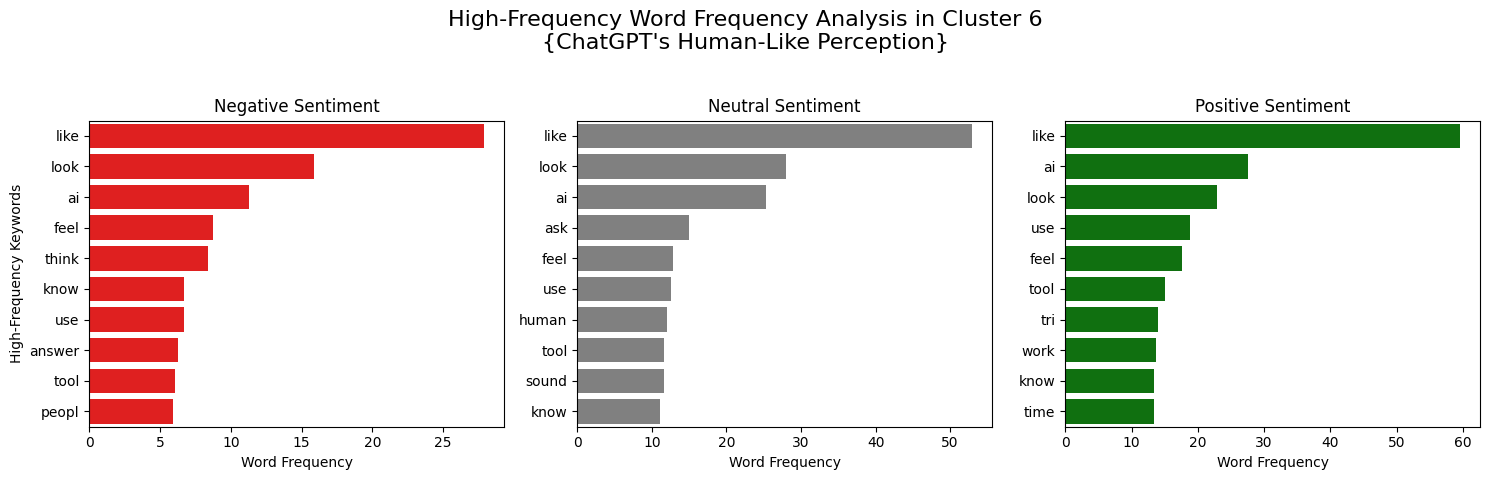

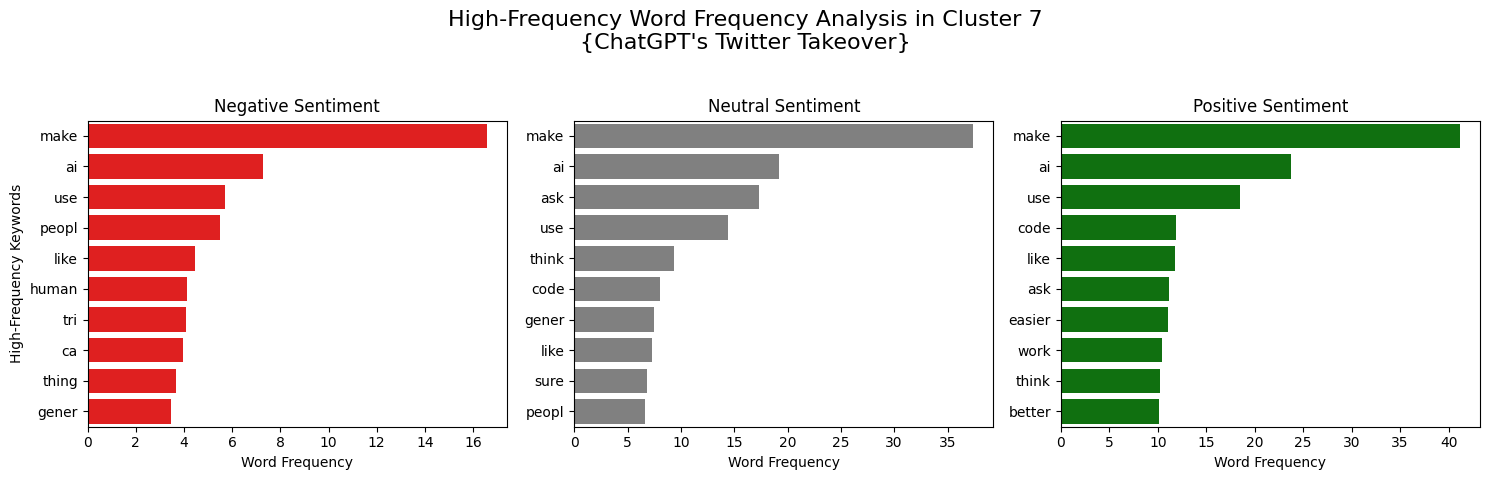

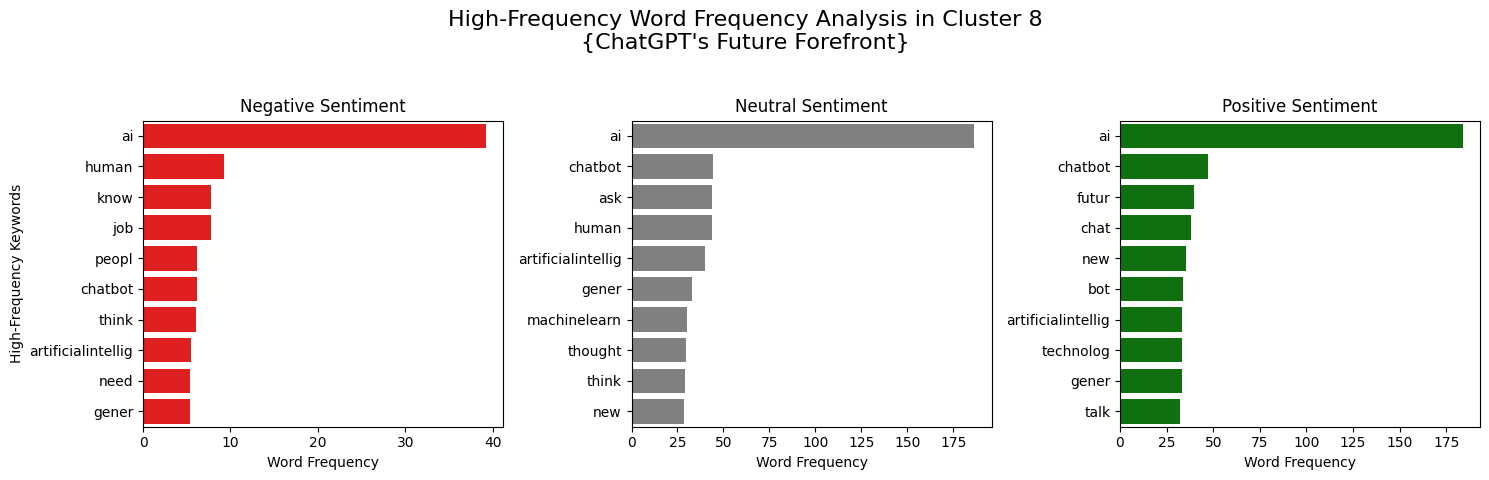

In [17]:
# Display keyword frequencies corresponding to different emotions in each cluster (showing the top 10)

cluster_titles = [
    "ChatGPT's Insightful Interactions",
    "ChatGPT's Cognitive Worldview",
    "ChatGPT's Creative Coding",
    "ChatGPT's Artistic Authorship",
    "ChatGPT's Diverse Dimensions",
    "ChatGPT's Search and Replace",
    "ChatGPT's Human-Like Perception",
    "ChatGPT's Twitter Takeover",
    "ChatGPT's Future Forefront"
]

sentiment_colors = {1: 'green', 0: 'gray', -1: 'red'}

cols_per_row = 3

for i in range(optimal_k):
    fig, axes = plt.subplots(1, cols_per_row, figsize=(15, 5))
    fig.suptitle("High-Frequency Word Frequency Analysis in Cluster "+str(i)+"\n"+"{"+cluster_titles[i]+"}", fontsize=16)

    for j, sentiment in enumerate([-1, 0, 1]):
        cluster_sentiment_text = df[(df['cluster'] == i) & (df['label_roberta'] == sentiment)]['preprocessed_text']
        
        if cluster_sentiment_text.empty:
            continue

        vectorizer = TfidfVectorizer(stop_words='english')
        word_count = vectorizer.fit_transform(cluster_sentiment_text)
        words = vectorizer.get_feature_names_out()
        counts = word_count.toarray().sum(axis=0)

        word_freq = sorted(zip(words, counts), key=lambda x: x[1], reverse=True)[:10]
        words, freqs = zip(*word_freq)

        ax = axes[j]
        sns.barplot(x=np.array(freqs), y=np.array(words), ax=ax, color=sentiment_colors[sentiment])

        sentiment_label = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}
        ax.set_title(f'{sentiment_label[sentiment]} Sentiment')

        if j == 0:
            ax.set_ylabel('High-Frequency Keywords')
        else:
            ax.set_ylabel('')
        ax.set_xlabel('Word Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()